### Definición del Problema de Clasificación 

Nuestro problema se aborda como uno de clasificación porque el objetivo principal es predecir qué equipo ganará una partida, asignando una etiqueta de entre dos posibles clases: 'Equipo Azul Gana' o 'Equipo Rojo Gana'. Para realizar esta predicción, el modelo utilizará un conjunto de variables de entrada tanto numéricas (duración de la partida, diferencia de oro, diferencia de asesinatos, daño total por equipo, número de centinelas por equipo) como categóricas (campeones utilizados por cada equipo y el equipo que obtuvo la primera sangre). El modelo aprenderá patrones a partir de estos datos para clasificar futuras partidas en una de las dos categorías de resultado.


In [6]:
# Importar librerías necesarias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos
try:
    df = pd.read_csv('../datos/partidas_lol.csv')
    print("Datos cargados exitosamente.")
    print(f"Dimensiones del DataFrame: {df.shape}")
except FileNotFoundError:
    print("Error: El archivo 'partidas_lol.csv' no se encontró.")
    print("Asegúrate de que el archivo CSV generado por el script de extracción esté en la misma carpeta que este notebook.")
    # Si el archivo no se encuentra, puedes detener la ejecución o proporcionar un DataFrame de ejemplo para que el resto del código no falle.
    # Para este ejemplo, si no encuentra el archivo, el script se detendrá.
    raise

# Mostrar información básica del DataFrame
print("\nInformación del DataFrame:")
df.info()
df

Datos cargados exitosamente.
Dimensiones del DataFrame: (884, 20)

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884 entries, 0 to 883
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   matchId                           884 non-null    object
 1   gameDuration                      884 non-null    int64 
 2   diff_gold                         884 non-null    int64 
 3   diff_kills                        884 non-null    int64 
 4   blue_totalDamageDealtToChampions  884 non-null    int64 
 5   red_totalDamageDealtToChampions   884 non-null    int64 
 6   blue_wardsPlaced                  884 non-null    int64 
 7   red_wardsPlaced                   884 non-null    int64 
 8   blue_champ1_name                  884 non-null    object
 9   blue_champ2_name                  884 non-null    object
 10  blue_champ3_name                  884 non-null    ob

,matchId,gameDuration,diff_gold,diff_kills,blue_totalDamageDealtToChampions,red_totalDamageDealtToChampions,blue_wardsPlaced,red_wardsPlaced,blue_champ1_name,blue_champ2_name,blue_champ3_name,blue_champ4_name,blue_champ5_name,red_champ1_name,red_champ2_name,red_champ3_name,red_champ4_name,red_champ5_name,firstBlood,blue_win
0,LA1_1608550617,2359,-6949,1,142182,148927,108,89,Gwen,Gragas,Zoe,Jhin,Thresh,Gangplank,Viego,Aurora,Tristana,Braum,1,0
1,LA1_1613637947,1139,10767,25,70004,46281,44,24,Pantheon,Nunu & Willump,Vladimir,Miss Fortune,Rell,Shen,Hecarim,Hwei,Yasuo,Alistar,0,1
2,LA1_1620124107,2043,-6521,-10,147880,156986,83,65,Urgot,Viego,Lissandra,Yasuo,Blitzcrank,Malphite,Jarvan IV,Vladimir,Smolder,Maokai,0,0
3,LA1_1607040918,1891,6096,13,113599,86762,90,60,Jayce,Talon,Aurelion Sol,Caitlyn,Karma,Irelia,Poppy,Akali,Tristana,Nami,0,1
4,LA1_1612640786,1009,4992,9,42414,37942,38,27,Kled,Hecarim,Aurora,Tristana,Yuumi,Gragas,Ekko,Zed,Lucian,Thresh,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879,LA1_1613796643,1528,-14449,-19,74918,105699,58,65,Malzahar,Rumble,Nasus,Lucian,Karma,Ryze,Xin Zhao,Corki,Draven,Seraphine,0,0
880,LA1_1619016692,1480,-9121,-10,66583,75044,55,48,Darius,Kha'Zix,Taliyah,Xayah,Thresh,Aatrox,Xin Zhao,Mordekaiser,Tristana,Lulu,1,0
881,LA1_1604282555,2103,4309,-1,168065,132952,79,77,Sion,Lillia,Vladimir,Kai'Sa,Seraphine,Darius,Viego,Cho'Gath,Jhin,Zilean,1,1
882,LA2_1503647110,2419,-1876,-4,187961,153168,89,102,Riven,Viego,Ahri,Ezreal,Sona,Tahm Kench,Nunu & Willump,Akali,Vayne,Rell,1,0


In [7]:
# Definir características numéricas y categóricas
numerical_features = [
    'gameDuration', 'diff_gold', 'diff_kills',
    'blue_totalDamageDealtToChampions', 'red_totalDamageDealtToChampions',
    'blue_wardsPlaced', 'red_wardsPlaced'
]

# Las IDs de los campeones son numéricas, pero representan categorías.
# 'firstBlood' también es 0/1 pero representa una categoría binaria.
categorical_features = [
    'blue_champ1_name', 'blue_champ2_name', 'blue_champ3_name', 'blue_champ4_name', 'blue_champ5_name',
    'red_champ1_name', 'red_champ2_name', 'red_champ3_name', 'red_champ4_name', 'red_champ5_name',
    'firstBlood'
]

# Definir la variable objetivo
target = 'blue_win'

# Separar características (X) y variable objetivo (y)
X = df[numerical_features + categorical_features]
y = df[target]

print(f"\nCaracterísticas (X) seleccionadas: {X.columns.tolist()}")
print(f"Variable objetivo (y): {target}")

# Crear un preprocesador usando ColumnTransformer
# Esto aplicará OneHotEncoder solo a las columnas categóricas
# y dejará las numéricas intactas.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features), # Pasa las numéricas sin cambios
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features) # Aplica One-Hot Encoding a las categóricas
    ])

print("\nPreprocesador configurado para One-Hot Encoding de características categóricas.")


Características (X) seleccionadas: ['gameDuration', 'diff_gold', 'diff_kills', 'blue_totalDamageDealtToChampions', 'red_totalDamageDealtToChampions', 'blue_wardsPlaced', 'red_wardsPlaced', 'blue_champ1_name', 'blue_champ2_name', 'blue_champ3_name', 'blue_champ4_name', 'blue_champ5_name', 'red_champ1_name', 'red_champ2_name', 'red_champ3_name', 'red_champ4_name', 'red_champ5_name', 'firstBlood']
Variable objetivo (y): blue_win

Preprocesador configurado para One-Hot Encoding de características categóricas.


In [ ]:
# Dividir los datos en conjuntos de entrenamiento y prueba
# test_size=0.3 significa que el 30% de los datos se usarán para prueba
# random_state asegura que la división sea la misma cada vez que ejecutes el código
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"\nDimensiones del conjunto de entrenamiento (X_train): {X_train.shape}")
print(f"Dimensiones del conjunto de prueba (X_test): {X_test.shape}")
print(f"Dimensiones del conjunto de entrenamiento (y_train): {y_train.shape}")
print(f"Dimensiones del conjunto de prueba (y_test): {y_test.shape}")


Dimensiones del conjunto de entrenamiento (X_train): (618, 18)
Dimensiones del conjunto de prueba (X_test): (266, 18)
Dimensiones del conjunto de entrenamiento (y_train): (618,)
Dimensiones del conjunto de prueba (y_test): (266,)


### División del conjunto de datos:
- Entrenamiento : Ocupamos un 70 % de los datos para el entrenamiento del modelo. 
- Prueba : Ocupamos un 30 % de los datos para la prueba del modelo.

Explicacion de la estrategia de división:ocupamos la proporcion 70-30 para asegurarnos de que el modelo tenga suficiente información para aprender y generalizar, al igual evaluar mejor las predicciones evaluadas en el modelo . 

### Selección y ajuste de hiperparámetros
- Hiperparámetros ocupados: Random State.

Explicacion: Para matener una division entre los datos de entrenamiento y prueba, ocupamos el random state para que la division sea la misma en cada iteracion.


In [9]:
# Crear un pipeline que primero preprocese los datos y luego aplique el modelo
# Modelo 1: Random Forest Classifier
print("\nEntrenando modelo: Random Forest Classifier...")
model_rf = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))]) # n_jobs=-1 usa todos los cores disponibles

# Entrenar el modelo
model_rf.fit(X_train, y_train)
print("Modelo Random Forest entrenado exitosamente.")

# MOdelo 2: Supporting Vector Classifier
print("\nEntrenando modelo: Support Vector Classifier...")
model_svc = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', SVC(kernel='linear', random_state=42))])
model_svc.fit(X_train, y_train)
print("Modelo Support Vector Classifier entrenado exitosamente.")

# Modelo 3: Regresión Logística (más simple, buena línea base)
print("\nEntrenando modelo: Logistic Regression...")
model_lr = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(solver='liblinear', random_state=42, max_iter=1000))])
model_lr.fit(X_train, y_train)
print("Modelo Logistic Regression entrenado exitosamente.")


Entrenando modelo: Random Forest Classifier...
Modelo Random Forest entrenado exitosamente.

Entrenando modelo: Support Vector Classifier...
Modelo Support Vector Classifier entrenado exitosamente.

Entrenando modelo: Logistic Regression...
Modelo Logistic Regression entrenado exitosamente.



--- Evaluación del Modelo Random Forest ---
Precisión (Accuracy): 0.9887

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       126
           1       0.99      0.99      0.99       140

    accuracy                           0.99       266
   macro avg       0.99      0.99      0.99       266
weighted avg       0.99      0.99      0.99       266



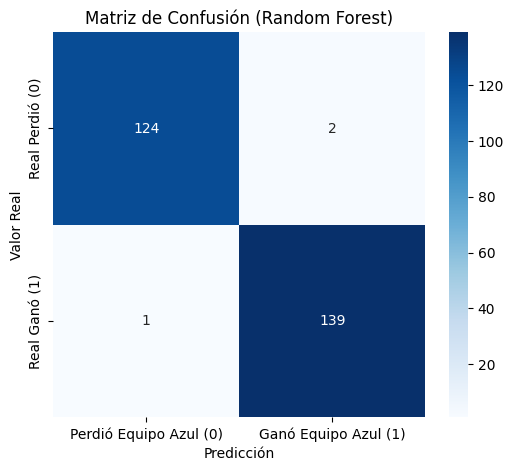


--- Evaluación del Modelo Support Vector Classifier ---
Precisión (Accuracy): 0.9925

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       126
           1       0.99      0.99      0.99       140

    accuracy                           0.99       266
   macro avg       0.99      0.99      0.99       266
weighted avg       0.99      0.99      0.99       266



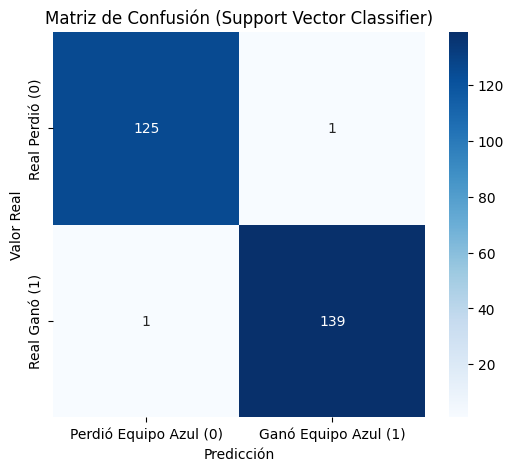


--- Evaluación del Modelo Logistic Regression ---
Precisión (Accuracy): 0.9850

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       126
           1       0.99      0.99      0.99       140

    accuracy                           0.98       266
   macro avg       0.98      0.98      0.98       266
weighted avg       0.98      0.98      0.98       266



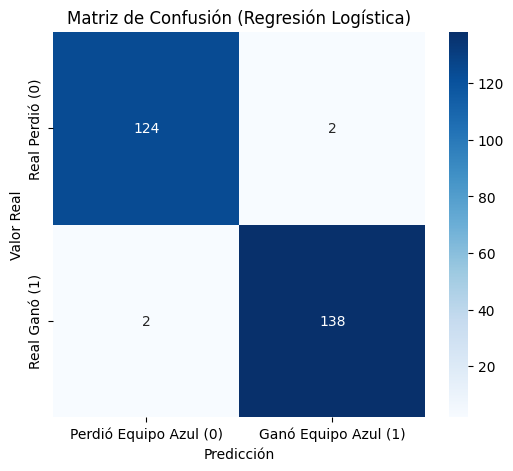

In [10]:
# Realizar predicciones en el conjunto de prueba
y_pred_rf = model_rf.predict(X_test)

print("\n--- Evaluación del Modelo Random Forest ---")
print(f"Precisión (Accuracy): {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_rf))

# Matriz de Confusión
cm_random = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_random, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Perdió Equipo Azul (0)', 'Ganó Equipo Azul (1)'],
            yticklabels=['Real Perdió (0)', 'Real Ganó (1)'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Random Forest)')
plt.show()

y_pred_svc = model_svc.predict(X_test)
print("\n--- Evaluación del Modelo Support Vector Classifier ---")
print(f"Precisión (Accuracy): {accuracy_score(y_test, y_pred_svc):.4f}")
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_svc))

# Matriz de Confusión para SVC
cm_svc = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Perdió Equipo Azul (0)', 'Ganó Equipo Azul (1)'],
            yticklabels=['Real Perdió (0)', 'Real Ganó (1)'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Support Vector Classifier)')
plt.show()

if 'model_lr' in locals():
    y_pred_lr = model_lr.predict(X_test)
    print("\n--- Evaluación del Modelo Logistic Regression ---")
    print(f"Precisión (Accuracy): {accuracy_score(y_test, y_pred_lr):.4f}")
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred_lr))

    # Matriz de Confusión para Regresión Logística
    cm_logistic = confusion_matrix(y_test, y_pred_lr)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_logistic, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Perdió Equipo Azul (0)', 'Ganó Equipo Azul (1)'],
            yticklabels=['Real Perdió (0)', 'Real Ganó (1)'])
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.title('Matriz de Confusión (Regresión Logística)')
    plt.show()

### Manejo de clases desbalanceadas
Las clases están balanceadas, ya que el número de partidas ganadas por cada equipo es similar. Esto significa que no es necesario aplicar técnicas de manejo de clases desbalanceadas, como el sobremuestreo o submuestreo.

### Metricas de evaluación 
- Metricas ocupadas: Accuracy, Precision, Recall y F1 Score.

Explicacion: as métricas Accuracy, Precision, Recall y F1 Score son apropiadas para este problema porque se trata de una tarea de clasificación binaria (predecir si gana el equipo azul o el rojo).

Accuracy (Precisión global): Indica el porcentaje de predicciones correctas sobre el total. Es útil cuando las clases están balanceadas.
Precision (Precisión): Mide la proporción de verdaderos positivos entre todas las predicciones positivas. Es importante si el costo de un falso positivo es alto.
Recall (Sensibilidad): Indica la proporción de verdaderos positivos detectados entre todos los casos reales positivos. Es relevante si el costo de un falso negativo es alto.
F1 Score: Es la media armónica entre precision y recall, útil cuando se busca un equilibrio entre ambas métricas, especialmente si las clases están desbalanceadas.
Estas métricas permiten comparar objetivamente el desempeño de los modelos, identificando cuál tiene mejor capacidad de predicción general y cuál maneja mejor los errores de clasificación en cada clase. Así, se puede seleccionar el modelo más adecuado según las necesidades del problema.

### Interpretación de resultados
Los datos obtenidos en graficos se encuentra arrib de este markdown, en la seccion de graficos.

### Reproducibilidad del experimento

Para garantizar la reproducibilidad del experimento, se ha establecido una semilla aleatoria (random state) en el modelo. Esto asegura que los resultados sean consistentes en diferentes ejecuciones, permitiendo que otros investigadores o desarrolladores puedan replicar el experimento y obtener resultados similares. Además, se han documentado todos los pasos del proceso, desde la carga de datos hasta la evaluación del modelo, para facilitar la comprensión y reproducción del trabajo realizado.

### Reflexión final: Limitaciones y posibles mejoras 

¿Qué elementos limitaron el rendimiento del modelo? (por ejemplo, tamaño del dataset, calidad de 
los atributos, clases desbalanceadas, etc.)

el tamaño del dataset pudo haber sido mayor acceso a la información de los jugadores. 



--------





¿Qué mejoras propondría si tuviera más empo o recursos? 

Con más tiempo o recursos, una mejora importante sería incorporar variables adicionales (features) que capturen con mayor detalle los eventos cruciales y la progresión de la partida. Estas podrían ser tanto numéricas como categóricas. Por ejemplo:

- Primera Torre Destruida:
   -  Categórica: Qué equipo la destruyó (Azul/Rojo).
   - Numérica: El tiempo de partida en que se destruyó la primera torre.
- Control de Objetivos Neutrales (Numérico):
   - Número de dragones elementales asesinados por cada equipo.
   - Número de heraldos de la grieta capturados.
   - Control del Barón Nashor (binaria: sí/no para cada equipo en un momento dado, o número de veces).
- Asesinatos de Monstruos de Jungla Relevantes (Numérico):
   - Número de mejoras (buffs) rojas y azules obtenidas por cada equipo.
 
La inclusión de estas variables es relevante porque la obtención de estos objetivos a menudo otorga bonificaciones significativas (oro, experiencia, estadísticas temporales o permanentes) que pueden influir directamente en la capacidad de un equipo para ganar enfrentamientos y, en última instancia, la partida. Serían, por lo tanto, características muy valiosas a considerar para el modelo.
